In [1]:
import sys
packages = [
    '../dataset/dataset/',
    '../utils/',
    '../optimizer/',
    '../loss/',
    '../model/'
]
sys.path.extend(packages)

from sklearn.model_selection import KFold
from util import getNowTime
from tqdm import tqdm
# from brpnet.model import UNet
from loss import dice_loss, smooth_truncated_loss, compute_loss_list,focal_loss,dice_loss_perimg
from adamw_r.cyclic_scheduler import CyclicLRWithRestarts, ReduceMaxLROnRestart
from adamw_r.adamw import AdamW
from ImageProcess.ImgShow import showLineImg
from PathologyData import PathologyDataSet
from KumarPatchDataSet import KumarPatchDataSet
import cv2
import torch.nn.functional as F
import time
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
from DataUtil import kfold_list
from postProcess.post_proc import post_proc
from metrics import get_fast_aji,remap_label
from dataset import PatchDataset
from patch_dense_net import UNet




In [2]:
# size176_train_npy = np.load('size176/size176_train_npy.npy')
# size176_sout_ins_npy = np.load('size176/size176_sout_ins_npy.npy')
# size176_cout_ins_npy = np.load('size176/size176_cout_ins_npy.npy')
# size176_pred_ins_npy = np.load('size176/size176_pred_ins_npy.npy') 
# size176_label_ins_npy = np.load('size176/size176_label_ins_npy.npy')
# position = 3
# showLineImg([size176_train_npy[position],size176_sout_ins_npy[position],size176_cout_ins_npy[position],size176_pred_ins_npy[position],size176_label_ins_npy[position]],figsize=(20,20),title=['image','semantic','boundary','pred','label'])

# size176_train_npy = np.load('size176/size176_train_npy.npy')
# size176_sout_ins_npy = np.load('size176/size176_sout_ins_npy.npy')
# size176_cout_ins_npy = np.load('size176/size176_cout_ins_npy.npy')
# size176_pred_ins_npy = np.load('size176/size176_pred_ins_npy.npy') 
# size176_label_ins_npy = np.load('size176/size176_label_ins_npy.npy')
# position = 0
# showLineImg([size176_train_npy[position],size176_sout_ins_npy[position],size176_cout_ins_npy[position],size176_pred_ins_npy[position],size176_label_ins_npy[position]],figsize=(20,20))

# d2, l2, sin2, cin2= patchDataset[789]
# showLineImg([np.transpose(d2,(1,2,0)),l2,sin2,cin2])


In [2]:
size176_train_npy = np.load('size48/size48_train_npy.npy')
size176_sout_ins_npy = np.load('size48/size48_sout_ins_npy.npy')
size176_cout_ins_npy = np.load('size48/size48_cout_ins_npy.npy')
size176_pred_ins_npy = np.load('size48/size48_pred_ins_npy.npy') 
size176_label_ins_npy = np.load('size48/size48_label_ins_npy.npy')

# size176_train_npy = np.load('size176/size176_train_npy.npy')
# size176_sout_ins_npy = np.load('size176/size176_sout_ins_npy.npy')
# size176_cout_ins_npy = np.load('size176/size176_cout_ins_npy.npy')
# size176_pred_ins_npy = np.load('size176/size176_pred_ins_npy.npy') 
# size176_label_ins_npy = np.load('size176/size176_label_ins_npy.npy')

print('大小尺寸：',size176_train_npy.shape)
patch_dataset = PatchDataset(size176_train_npy, size176_sout_ins_npy, size176_cout_ins_npy, size176_pred_ins_npy, size176_label_ins_npy)
dataloader = DataLoader(patch_dataset,batch_size=1,shuffle=False, num_workers=4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')





大小尺寸： (1164, 48, 48, 3)


In [6]:
# del model
model = UNet(3,2,1).to(device)
# patchNet/size76_model_epoch_9.pth
# patchNet/size48_model_epoch_9.pth
model.load_state_dict(torch.load('size48_model_epoch_9.pth'),device)


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([1, 3, 48, 48]) torch.Size([1, 1, 48, 48])


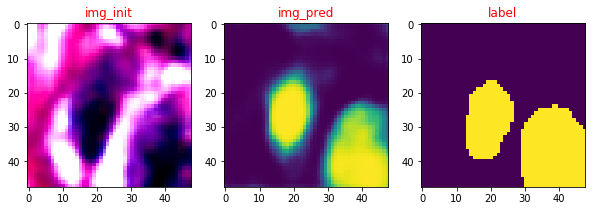

In [8]:
sigmoid = nn.Sigmoid()
for index,(image, label, s_in, c_in) in enumerate(dataloader):
    image_tensor = image.float().to(device)
    label_tensor = label.float().unsqueeze(dim=1).to(device)
    s_in_tensor = s_in.float().unsqueeze(dim=1).to(device)
    c_in_tensor = c_in.float().unsqueeze(dim=1).to(device)
    b, _, h, w = image.shape
    sout = model(image_tensor, torch.cat((s_in_tensor, c_in_tensor), dim=1))
    print(image.shape,sout.shape)
    # 输出的预测值的大小
    img_init = image_tensor[0].permute(1,2,0).cpu().data.numpy()
    img_pred = sigmoid(sout[0][0]).cpu().data.numpy()
    
    showLineImg([img_init,img_pred,label[0]],title=['img_init','img_pred','label'])
    break
